In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset
import json
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
pip install datasets torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset
ds = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
train = pd.DataFrame(ds['train'])
test = pd.DataFrame(ds['test'])

In [7]:
X_train, X_test =  train['text'], test['text']

In [8]:
X_train, X_val =  train_test_split(
    X_train, test_size=0.1, random_state=42)

In [9]:
print(len(X_train), len(X_val), len(X_test))

22500 2500 25000


In [10]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [11]:
tokenizer.vocab_size

28996

In [12]:
list(tokenizer.vocab)[:10]

['on',
 'Invisible',
 '##石',
 'Clubs',
 'Р',
 'gives',
 '##mott',
 'pass',
 '##ث',
 'Herman']

In [13]:
X_train   = tokenizer(X_train.to_list())
X_val     = tokenizer(X_val.to_list())
X_test    = tokenizer(X_test.to_list())

Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors


In [14]:
tokenizer("Attention Is All You Need")

{'input_ids': [101, 1335, 5208, 2116, 2181, 1398, 1192, 12528, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
tokenizer.tokenize("Attention Is All You Need")

['At', '##ten', '##tion', 'Is', 'All', 'You', 'Need']

In [41]:
tokenizer("Attention Is All You Need").word_ids()

[None, 0, 0, 0, 1, 2, 3, 4, None]

In [16]:
tokenizer("Gradients")

{'input_ids': [101, 144, 9871, 24767, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [17]:
tokenizer.tokenize("Gradients")

['G', '##rad', '##ients']

In [18]:
tokenizer.pad_token_id, tokenizer.mask_token_id

(0, 103)

In [19]:
def data_generator(X, max_len=512, batch_size=32, shuffle_data=True, pad_token_id=tokenizer.pad_token_id):

    input_ids = X['input_ids']
    att_mask = X['attention_mask']

    if shuffle_data:
        input_ids, att_mask = shuffle(input_ids, att_mask)

    n_batches = int(np.ceil(len(input_ids) / batch_size))

    for batch in range(n_batches):
        end = min((batch + 1) * batch_size, len(input_ids))

        input_ids_batch = input_ids[batch * batch_size:end]
        att_mask_batch = att_mask[batch * batch_size:end]

        batch_max_len = np.max([len(x) for x in input_ids_batch])
        batch_max_len = min(batch_max_len, max_len)

        for sample in range(len(input_ids_batch)):
            x = input_ids_batch[sample]
            if len(x) > batch_max_len:
                x = x[-batch_max_len:]
            pad = [pad_token_id] * (batch_max_len - len(x))
            input_ids_batch[sample] = pad + x

            x = att_mask_batch[sample]
            if len(x) > batch_max_len:
                x = x[-batch_max_len:]
            pad = [0] * (batch_max_len - len(x))
            att_mask_batch[sample] = pad + x

        input_ids_batch = torch.from_numpy(np.array(input_ids_batch)).long()
        att_mask_batch = torch.from_numpy(np.array(att_mask_batch)).long()

        yield input_ids_batch, att_mask_batch

In [20]:
torch.roll(torch.tensor([1, 2, 3]), shifts=-1, dims=0)

tensor([2, 3, 1])

In [21]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               device):

    model.train()

    train_loss = []

    for input_ids, att_mask in data_loader():
        input_ids, att_mask = input_ids.to(device), att_mask.to(device)
        optimizer.zero_grad()

        # shift targets backwards
        targets = input_ids.clone().detach()
        targets = torch.roll(targets, shifts=-1, dims=1)
        targets[:, -1] = tokenizer.pad_token_id
        # targets.shape: [n_samples, max_seq_len]

        y_pred = model(input_ids, att_mask)
        # y_pred.shape: [n_samples, max_seq_len, vocab_size]
        # but PyTorch expects [n_samples, vocab_size, max_seq_len]
        loss = loss_fn(y_pred.transpose(2, 1), targets)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

def test_step(model,
              data_loader,
              loss_fn,
              optimizer,
              device):
    model.eval()

    test_loss = []

    with torch.inference_mode():
        for input_ids, att_mask in data_loader():
            input_ids, att_mask = input_ids.to(device), att_mask.to(device)
            optimizer.zero_grad()

            targets = input_ids.clone().detach()
            targets = torch.roll(targets, shifts=-1, dims=1)
            targets[:, -1] = tokenizer.pad_token_id
            # targets.shape: [n_samples, max_seq_len]
            y_pred = model(input_ids, att_mask)
            # y_pred.shape: [n_samples, max_seq_len, vocab_size]
            # but PyTorch expects [n_samples, vocab_size, max_seq_len]
            loss = loss_fn(y_pred.transpose(2, 1), targets)

            test_loss.append(loss.item())

    return np.mean(test_loss)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "test_loss": [],
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss = train_step(model=model,
                                          data_loader=train_data_loader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        end_time = timer()
        test_loss = test_step(model=model,
          data_loader=test_data_loader,
          loss_fn=loss_fn,
          device=device)

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"time: {(end_time-start_time):.4f}"
        )

    return results

In [22]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()


In [23]:
cm = torch.tril(torch.ones(5, 5)).view(1, 1, 5, 5)
cm

tensor([[[[1., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0.],
          [1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1.]]]])

In [24]:
cm.masked_fill(cm[:, :, :5, :5] == 0, float('-inf'))

tensor([[[[1., -inf, -inf, -inf, -inf],
          [1., 1., -inf, -inf, -inf],
          [1., 1., 1., -inf, -inf],
          [1., 1., 1., 1., -inf],
          [1., 1., 1., 1., 1.]]]])

In [42]:
torch.ones([1, 4])

tensor([[1., 1., 1., 1.]])

In [44]:
tensor = torch.ones([1, 4])
tensor[:, None, None, :]

tensor([[[[1., 1., 1., 1.]]]])

In [26]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, max_len):
        # D: d_model i.e. model size
        # d_v: value head size
        # d_k: key head size
        # h: n_heads
        # Assume d_v = d_k
        super().__init__()
        assert d_model % n_heads == 0
        d_k = d_model // n_heads
        self.d_k = d_k
        self.n_heads = n_heads

        self.key = nn.Linear(d_model, d_k * n_heads)
        self.query = nn.Linear(d_model, d_k * n_heads)
        self.value = nn.Linear(d_model, d_k * n_heads)

        self.fc = nn.Linear(d_k * n_heads, d_model)

        # causal mask
        cm = torch.tril(torch.ones(max_len, max_len))
        self.register_buffer(
            "causal_mask",
            cm.view(1, 1, max_len, max_len)
        )

    def forward(self, q, k, v, pad_mask=None):
        # D: d_model i.e. model size
        # N: n_samples
        # d_v: value head size
        # d_k: key head size
        # h: n_heads
        # T: seq_len i.e. time steps
        # Assume d_v = d_k
        # q.shape == k.shape == v.shape == N x T x D == N x T x (h * d_k)
        q = self.query(q) # N x T x (h * d_k)
        k = self.key(k)   # N x T x (h * d_k)
        v = self.value(v) # N x T x (h * d_v)

        N = q.shape[0]
        T = q.shape[1]

        # change the shape to:
        # (N, T, h, d_k) -> (N, h, T, d_k)
        q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)

        # compute attention weights
        # for i in 1..N:
        #     for j in 1..h:
        #         T, d_k x d_k, T -> T, T
        #
        # (N, h, T, d_k) x (N, h, d_k, T) --> (N, h, T, T)
        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
        if pad_mask is not None:
            attn_scores = attn_scores.masked_fill(
                pad_mask[:, None, None, :] == 0, float('-inf'))

        attn_scores = attn_scores.masked_fill(
              self.causal_mask[:, :, :T, :T] == 0, float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)

        # compute attention-weighted values
        # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
        A = attn_weights @ v

        # reshape it back before final linear layer
        A = A.transpose(1, 2) # (N, T, h, d_k)
        A = A.contiguous().view(N, T, self.d_k * self.n_heads) # (N, T, h * d_k)

        return self.fc(A) # shape: N x T x D

In [27]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, max_len, dropout_prob=0.1):
        super().__init__()

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = CausalSelfAttention(d_model, n_heads, max_len)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout_prob),
        )
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, pad_mask=None):
        x = self.ln1(x + self.mha(x, x, x, pad_mask))
        x = self.ln2(x + self.ann(x))
        x = self.dropout(x)
        return x

In [28]:
torch.arange(5).unsqueeze(1)

tensor([[0],
        [1],
        [2],
        [3],
        [4]])

In [45]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [29]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout_prob=0.1):
        # N: n_samples
        # T: seq_len i.e. time steps
        # D: d_model i.e. model size
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_prob)

        position = torch.arange(max_len).unsqueeze(1)
        # possition.shape: 1 x T
        exp_term = torch.arange(0, d_model, 2)
        div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        # pe.shape: 1 x T x D
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x.shape: N x T x D
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [30]:
pe = PositionalEncoding(4)

pe(torch.ones([1, 8, 4]))

tensor([[[1.1111, 2.2222, 1.1111, 2.2222],
         [2.0461, 1.7114, 1.1222, 2.2222],
         [2.1214, 0.0000, 1.1333, 2.2220],
         [1.2679, 0.0111, 1.1444, 2.2217],
         [0.2702, 0.0000, 1.1555, 2.2213],
         [0.0456, 1.4263, 1.1666, 2.2208],
         [0.8006, 2.1780, 1.1777, 2.2202],
         [1.8411, 1.9488, 1.1888, 2.2195]]])

In [31]:
def example_positional():
    import altair as alt

    pe = PositionalEncoding(20, max_len=100, dropout_prob=0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

example_positional()

alt.Chart(...)

In [32]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 max_len,
                 d_model,
                 n_heads,
                 n_layers,
                 dropout_prob):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        transformer_blocks = [
            TransformerBlock(
                d_model,
                n_heads,
                max_len,
                dropout_prob) for _ in range(n_layers)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.ln = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x, pad_mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
            x = block(x, pad_mask)
        x = self.ln(x)
        x = self.fc(x)
        return x

In [33]:
tokenizer.pad_token_id

0

In [34]:
train_gen   = lambda : data_generator(X_train, max_len=256, batch_size=32)
val_gen     = lambda : data_generator(X_val, max_len=256, shuffle_data=False)
test_gen    = lambda : data_generator(X_test, max_len=256, shuffle_data=False)

In [35]:
model = Decoder(
    vocab_size=tokenizer.vocab_size,
    max_len=256,
    d_model=512,
    n_heads=8,
    n_layers=6,
    dropout_prob=0.1
)
model.to(device)

Decoder(
  (embedding): Embedding(28996, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mha): CausalSelfAttention(
        (key): Linear(in_features=512, out_features=512, bias=True)
        (query): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (fc): Linear(in_features=512, out_features=512, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((5

Decoder(
  (embedding): Embedding(28996, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mha): CausalSelfAttention(
        (key): Linear(in_features=512, out_features=512, bias=True)
        (query): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (fc): Linear(in_features=512, out_features=512, bias=True)
      )
      (ann): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (ln1): LayerNorm((5

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.5823 | test_loss: 4.9838 | time: 464.7206
Epoch: 2 | train_loss: 4.7979 | test_loss: 4.6692 | time: 466.1058
Epoch: 3 | train_loss: 4.5429 | test_loss: 4.5071 | time: 467.1412
Epoch: 4 | train_loss: 4.3859 | test_loss: 4.4314 | time: 466.7929
Epoch: 5 | train_loss: 4.2718 | test_loss: 4.3633 | time: 467.1034
Epoch: 6 | train_loss: 4.1816 | test_loss: 4.3242 | time: 467.0274
Epoch: 7 | train_loss: 4.1093 | test_loss: 4.2880 | time: 467.2723
Epoch: 8 | train_loss: 4.0417 | test_loss: 4.2743 | time: 467.1624
Epoch: 9 | train_loss: 3.9866 | test_loss: 4.2522 | time: 466.5836
Epoch: 10 | train_loss: 3.9308 | test_loss: 4.2483 | time: 466.7408


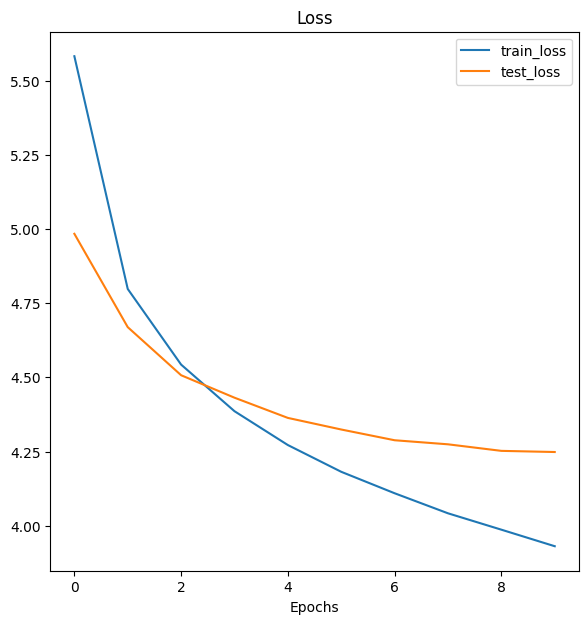

In [ ]:
print(model)

loss = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = train(model=model,
          train_data_loader = train_gen,
          test_data_loader = val_gen,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 10,
          device = device)

plot_loss_curves(results)

In [ ]:
np.exp(4) / 0.75

72.79753337752565

In [ ]:
# torch.save(model, 'gpt_model.pt')

In [36]:
model = torch.load('gpt_model.pt', map_location=torch.device(device))

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [ ]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])
torch.hstack((a,b))

tensor([1, 2, 3, 4, 5, 6])

In [ ]:
a = torch.tensor([[1],[2],[3]])
b = torch.tensor([[4],[5],[6]])
torch.hstack((a,b))

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [37]:
def generate(model, prompt='', max_len=32):
    tokenized_prompt = tokenizer(prompt, return_tensors='pt')
    input_ids = tokenized_prompt['input_ids'][:, :-1].to(device)
    mask = tokenized_prompt['attention_mask'][:, :-1].to(device)

    while(len(input_ids[0]) < max_len):
        outputs = model(input_ids, mask)
        # outputs 1 x T x D
        prediction_id = torch.argmax(outputs[:, -1, :], axis=-1)

        if prediction_id.squeeze(0).item() == tokenizer.sep_token_id:
            break

        input_ids = torch.hstack((input_ids, prediction_id.view(1, 1)))
        mask = torch.ones_like(input_ids)

    return tokenizer.decode(input_ids[0][1:])

In [ ]:
generate(model, "Blade Runner")

'Blade Runner is a great movie. I love the way the characters are played by the main character, the story is a little too much. I love the'

In [ ]:
generate(model, "Dune is ")

'Dune is a great movie. I love the way the characters are played by the main character of the two leads. I love the way the characters are'

In [ ]:
generate(model, "The worst ")

'The worst thing about this movie is that it is so bad that it is so bad that it is so bad. The acting is terrible, the plot is'

In [ ]:
generate(model, "Facinating ")

'Facinatingally, the movie was a complete waste of time. I was hoping for a movie that was made in the past. The acting was terrible'

In [38]:
def generate_with_temp(model, prompt='', max_len=32, temperature=0.4):
    tokenized_prompt = tokenizer(prompt, return_tensors='pt')
    input_ids = tokenized_prompt['input_ids'][:, :-1].to(device)
    mask = tokenized_prompt['attention_mask'][:, :-1].to(device)

    while(len(input_ids[0]) < max_len):
        outputs = model(input_ids, mask)
        y = outputs[:, -1, :][0]
        distribution = torch.nn.functional.softmax(y / temperature, dim=0)
        prediction_id = np.random.choice(tokenizer.vocab_size, p=distribution.cpu().detach().numpy())

        if prediction_id == tokenizer.sep_token_id:
            break

        input_ids = torch.hstack((input_ids, torch.tensor(prediction_id).to(device).view(1, 1)))
        mask = torch.ones_like(input_ids)

    return tokenizer.decode(input_ids[0][1:])

In [ ]:
generate_with_temp(model, "Facinating ")

"Facinatingally, this movie was a great disappointment. I don't know what to expect in this movie, but I have to admit that I"

In [ ]:
generate_with_temp(model, "Dune is ")

'Dune is a wonderful film. The film is a true story of a young girl who is a young girl who is in love with her love and love'

In [ ]:
generate_with_temp(model, "The worst ")

"The worst thing about this movie is that it's a lot of fun. The acting is terrible, the story is awful, the acting is bad,"

In [ ]:
generate_with_temp(model, "Facinating ")

'Facinatingally, the film is a very entertaining and entertaining. The acting is really good, though, the story is good, the acting is good'